In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas  to Load the data</h3>

In [12]:
data = pd.read_csv('train.csv')

<h3> 3.1.2 Counting the number of rows </h3>

In [14]:
data.shape

(6034195, 4)

In [15]:
data.columns

Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')

<h3>3.1.3 Checking for duplicates </h3>

In [23]:
data = data.drop_duplicates(subset={'Id', 'Title', 'Body', 'Tags'})

<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [32]:
data.dropna(inplace=True)

In [33]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(data['Tags'])

In [34]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 6034187
Number of unique tags : 42048


In [35]:
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 3.2.3 Number of times a tag appeared </h3>

In [45]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [50]:
tag_dtm.sum(axis=0)

matrix([[23, 55,  2, ..., 15, 52,  1]], dtype=int64)

In [53]:
tag_dtm.shape

(6034187, 42048)

In [54]:
freqs.shape

(42048,)

In [84]:
tag_df = pd.DataFrame()

In [89]:
tag_df['Tags'] = result.keys()
tag_df['Counts'] = result.values()

In [91]:
tag_df.head()

Tags  Counts
0             .a      23
1           .app      55
2   .asp.net-mvc       2
3      .aspxauth      28
4  .bash-profile     210

In [92]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

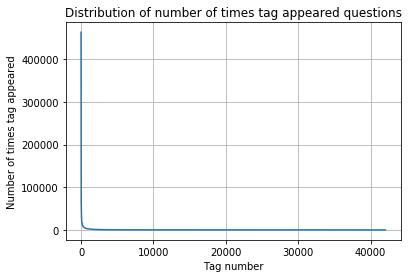

In [93]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

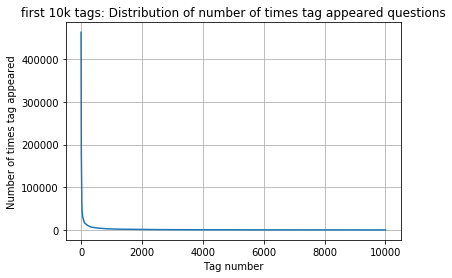

400 [463526  62239  32280  25872  18936  15701  14480  13275  11372  10553
   9275   8413   7679   7178   6586   6242   5906   5672   5326   5136
   4964   4726   4567   4358   4169   3940   3794   3630   3537   3393
   3277   3171   3062   2949   2849   2713   2626   2530   2455   2386
   2317   2257   2191   2143   2099   2046   2004   1955   1923   1879
   1830   1801   1772   1730   1700   1660   1633   1588   1563   1534
   1507   1483   1455   1427   1397   1372   1345   1323   1302   1285
   1264   1249   1231   1210   1189   1172   1157   1145   1129   1111
   1088   1073   1058   1043   1030   1012    999    985    964    953
    940    927    915    908    893    881    870    859    848    835
    823    812    803    794    781    769    759    748    739    731
    722    713    703    694    687    680    671    665    659    650
    645    638    631    624    618    611    603    594    590    585
    577    572    567    560    554    547    543    538    532    526
  

In [95]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

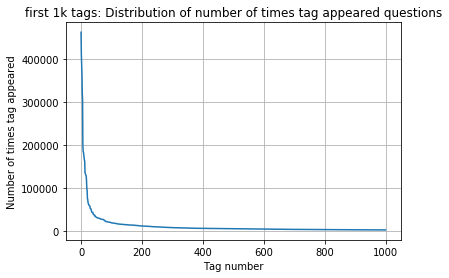

200 [463526 305614 172182 132465  95453  62239  52513  44092  39377  34499
  32280  30141  29382  27458  26932  25872  22309  21427  20586  20193
  18936  18363  17713  17245  16323  15701  15560  15343  14863  14695
  14480  14113  13805  13579  13366  13275  12895  12482  12090  11742
  11372  11309  11147  10909  10723  10553  10139   9870   9651   9450
   9275   9180   9080   8892   8573   8413   8189   8028   7925   7799
   7679   7498   7405   7341   7258   7178   7091   6969   6897   6762
   6586   6511   6398   6358   6312   6242   6143   6064   6044   5946
   5906   5851   5793   5764   5714   5672   5604   5554   5462   5443
   5326   5282   5250   5224   5182   5136   5097   5058   5022   4994
   4964   4920   4880   4810   4777   4726   4706   4675   4636   4605
   4567   4531   4475   4454   4400   4358   4313   4264   4205   4186
   4169   4125   4093   4076   3984   3940   3915   3875   3842   3816
   3794   3771   3733   3702   3673   3630   3614   3595   3578   3568
  

In [96]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

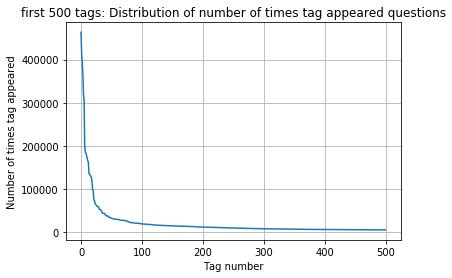

100 [463526 305614 172182 132465  95453  62239  52513  44092  39377  34499
  32280  30141  29382  27458  26932  25872  22309  21427  20586  20193
  18936  18363  17713  17245  16323  15701  15560  15343  14863  14695
  14480  14113  13805  13579  13366  13275  12895  12482  12090  11742
  11372  11309  11147  10909  10723  10553  10139   9870   9651   9450
   9275   9180   9080   8892   8573   8413   8189   8028   7925   7799
   7679   7498   7405   7341   7258   7178   7091   6969   6897   6762
   6586   6511   6398   6358   6312   6242   6143   6064   6044   5946
   5906   5851   5793   5764   5714   5672   5604   5554   5462   5443
   5326   5282   5250   5224   5182   5136   5097   5058   5022   4994]


In [97]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

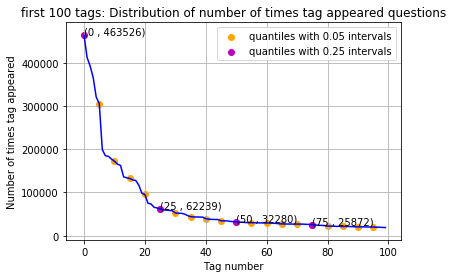

20 [463526 305614 172182 132465  95453  62239  52513  44092  39377  34499
  32280  30141  29382  27458  26932  25872  22309  21427  20586  20193]


In [100]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [102]:
#tags greater than 10K
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
#tags greater than 100K
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

234 Tags are used more than 10000 times
19 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 234 tags which are used more than 10000 times.
2. 19 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 463526 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [107]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 6034187 datapoints.
[5, 1, 3, 3, 3]


In [121]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.885225


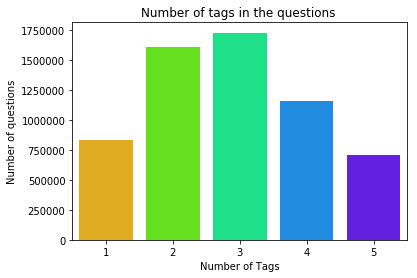

In [122]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

In [131]:
# Ploting word cloud
start = datetime.now()


#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(result)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:07.469194


<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 30 tags </h3>

In [135]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 0.5M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [334]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
def stripcode(data):
    # flags= re.DOTALL matches \n also
    return re.sub('<code>(.*?)</code>', '', str(data), flags=re.MULTILINE|re.DOTALL),str(re.findall(r'<code>(.*?)</code>', str(data), flags=re.DOTALL))
def stripunc(data):
    return re.sub('[^A-Za-z]+', ' ', str(data), flags=re.MULTILINE|re.DOTALL)
    
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [147]:
sampled_data = data.sample(500000, random_state=0)

In [151]:
sampled_data.shape

(500000, 4)

In [155]:
sampled_data.reset_index(drop=True, inplace=True)

In [210]:
# flags= re.DOTALL matches \n also
str(re.findall(r'<code>(.*?)</code>', sampled_data['Body'][16], flags=re.DOTALL))

'[\'$question_text = sanitize($_POST[\\\'question_text\\\']);\\n\\nlist($first_word) = explode(\\\' \\\', $question_text);\\n\\n$qStuff=mysql_query("SELECT c.field_name,t.category_name, d.domain_name FROM category_fields c, taxonomy_category t, taxonomy_domain d WHERE c.category_id = t.category_id AND t.domain_id = d.domain_id AND c.field_name = \\\'$first_word\\\'");\\n\']'

In [231]:
str(re.findall(r'[^A-Za-z]+', sampled_data['Body'][11], flags=re.DOTALL))

"['<', '>', ' ', ' ', ' ', ' ', ' ', ' ', ' (', '?) ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ', ', '/', ' ', ' ', ' ', '-', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '.</', '>\\n\\n<', '>', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '?</', '>\\n']"

In [237]:
sampled_data.columns

Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')

In [338]:
def compute(qtup):
    tid = qtup[0]
    ttitle = qtup[1]
    tbody = qtup[2]
    ttags = qtup[3]
    
    tbody,code = stripcode(tbody)
    #ttitle=ttitle.encode('utf-8')
    tbody = str(ttitle)+" "+str(tbody)
    tbody = stripunc(tbody)
    words=word_tokenize(str(tbody.lower()))
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    tbody=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    return pd.Series([tid,tbody,ttags,code])

In [342]:
results = sampled_data[['Id','Title','Body','Tags']].apply(compute,axis=1)

In [344]:
results.columns = ['Id','Question','Tags','Code']

In [346]:
results.head(20)

Id                                           Question  \
0   2720241  deploy net librari com built class librari reg...   
1   1356755  cleaner way remov substr str c follow string w...   
2   4486033  asp mvc stringlengthattribut would like know s...   
3    491308  jstl work like articl place follow file web in...   
4    594570  chang drop button combobox control chang dropd...   
5   4677103  cleanup huge perl codebas current work rough y...   
6   1010305  access file linux make sure program one access...   
7    977876  nosuchmethoderror spring tomcat app tri implem...   
8   1135918  pleas explain mail valid regular express scrip...   
9   2660745  scalabl pojo remot servic intern java client w...   
10  1898372  display unicod charact textview android number...   
11  3990605  automat name xp node dhcp dns one thing mani l...   
12   768631  redirect request public directori zend sub dom...   
13  4322205  asp net objectdatasourc problem common structu...   
14  3547177  relat path program run debug mode vs debug pro...   
15  3747203  open link new window javascript blockquot stro...   
16  1423258  sanit queri someon teach sanit queri sanit fir...   
17  5409130  jqueri slider slideshow good jqueri slider mov...   
18   883775  target list item per two list instead even odd...   
19  5293298  rebuild templat map modul bootstrap need rebui...   

                                            Tags  \
0                                       .net com   
1                     c string substring memmove   
2                                  asp.net-mvc-3   
3                                  java jsp jstl   
4                              c# winforms forms   
5         perl web-applications cgi code-cleanup   
6                                c linux file-io   
7          spring tomcat maven nosuchmethoderror   
8                                     javascript   
9                      java rmi pojo apache-mina   
10                                       android   
11                               windows-xp dhcp   
12       zend-framework .htaccess web-deployment   
13                      asp.net objectdatasource   
14  c# visual-studio-2010 projects-and-solutions   
15                                    javascript   
16                                     php mysql   
17                 jquery jquery-plugins sliders   
18                                        jquery   
19              templates layout zend-framework2   

                                                 Code  
0                                                  []  
1   ['ID is a sample string remove to /0.10', 'ID/...  
2                                                  []  
3                                                  []  
4                            ['ComboBox', 'ComboBox']  
5   ['use', 'require', 'use', 'require', 'warnings...  
6                                                  []  
7   ['Base64.encodeBase64String(rawBytes)\n', 'SEV...  
8   ['var emailfilter=/^\\w+[\\+\\.\\w-]*@([\\w-]+...  
9                                                  []  
10                                                 []  
11                                                 []  
12  ['abc', 'public', '.htaccess', 'public', "&lt;...  
13  ['public class User\n{\n    public int ID { ge...  
14  ['  Stream s = File.Open("usr.dat", FileMode.O...  
15  ['&lt;div class="sponsor" target="_blank" oncl...  
16  ['$question_text = sanitize($_POST[\'question_...  
17                                                 []  
18  ['&lt;li&gt;&lt;!-- blue --&gt;&lt;/li&gt;\n&l...  
19  ["application.theme = 'default'", "'view_manag...

In [348]:
results.to_csv('data.csv',index=False)

In [349]:
final_data = pd.read_csv('data.csv')

In [359]:
print("Questions after pre-processing:")
for a in final_data['Question'].head(10):
    print(a)
    print("*"*100)

Questions after pre-processing:
deploy net librari com built class librari regist com access use visual studio build option librari access excel vba creat msi instal anoth comput use excel file
****************************************************************************************************
cleaner way remov substr str c follow string would like end follow came howev look cleaner nicer way pre pre
****************************************************************************************************
asp mvc stringlengthattribut would like know stringlengthattribut actual work see defin one properti modelmetada class still htmlhelper generat relat html attribut proper get
****************************************************************************************************
jstl work like articl place follow file web inf lib folder applicaion ul li standard jar li li jstl jar li ul taglib state would resolv uri tag tld taglib deploy jar file web inf lib applic keep throw error found tag li

In [383]:
count = 0
for c in final_data['Code']:
    if c=='[]':
        count += 1

In [391]:
print("Percentage of questions containing code : %f"% np.round(((final_data.shape[0] - count) / final_data.shape[0]) * 100, 3))

Percentage of questions containing code : 56.075000


In [393]:
processed_data = final_data[['Question','Tags']]

In [394]:
processed_data.head()

Question  \
0  deploy net librari com built class librari reg...   
1  cleaner way remov substr str c follow string w...   
2  asp mvc stringlengthattribut would like know s...   
3  jstl work like articl place follow file web in...   
4  chang drop button combobox control chang dropd...   

                         Tags  
0                    .net com  
1  c string substring memmove  
2               asp.net-mvc-3  
3               java jsp jstl  
4           c# winforms forms